In [12]:
import os
import numpy as np
from astropy.io import fits
from astropy.stats import *
from astropy import coordinates, time
from astropy import units as u
from photutils.background import Background2D, MedianBackground
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import *
from scipy.signal import square

In [13]:
#first we're going to find all our fits files.
#Change your in_path to the directory containing all your fits files. Sort them by observation date.
in_path = r"C:\Users\Sam Whitebook\GJ3470b"

#Loading in our fits files
files = os.listdir(in_path)
files = np.array(files)

In [14]:
#Function Box
def extractor(files):
    data = []
    headers = []
    for i in range(len(files)):
        data_i = fits.open(in_path + "\\" + files[i])[0].data
        header_i = fits.open(in_path + "\\" + files[i])[0].header
        data.append(data_i)
        headers.append(header_i)
    return data, headers

def photometry(data, header):
    pos_lists = [[] for _ in range(len(data))]
    mag_lists = [[] for _ in range(len(data))]
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = MedianBackground()
    frames = []
    times = []
    for j in range(len(data)):
        #Here frames is just an array counting the total number of images taken as the function parses through them.
        frames.append(j)
        times.append(header[j]["MJD-OBS"])
        mean, median, std = sigma_clipped_stats(data[j], sigma=3.0)
        bkg = Background2D(data[j], (50, 50), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
        bkg_median = bkg.background_median
        daofind = DAOStarFinder(fwhm=10, threshold=5*std)
        sources = daofind(data[j] - bkg_median)
        positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
        apertures = CircularAperture(positions, r=15)
        phot_table = aperture_photometry(data[j] - bkg_median, apertures)
        mags_j = phot_table['aperture_sum']
        pos_j = [phot_table['xcenter'], phot_table['ycenter']]
        mag_lists[j] = mags_j
        pos_lists[j] = pos_j
    return frames, times, pos_lists, mag_lists

def calibrator(pos, mags, cal_star, cal_pix):
    cal_lists = [[] for _ in range(len(mags))]
    zp_x = cal_pix[0][0]
    zp_y = cal_pix[1][0]
    for k in range(len(pos)):
        phot_x = pos[k][0]
        phot_y = pos[k][1]
        star_x = cal_star[0] + cal_pix[0][k] - zp_x
        star_y = cal_star[1] + cal_pix[1][k] - zp_y
        r = np.sqrt((phot_x.value - star_x)**2 + (phot_y.value - star_y)**2)
        index = np.where(r == np.min(r))[0][0]
        cal_lists[k] = mags[k][index]
    return cal_lists
    

As it turns out, our files are already sorted chronologically, and they all used the same filter. Lucky us, but it's still good practice to check!

In [15]:
#Extract data and headers from every file.
data = extractor(files)[0]
headers = extractor(files)[1]

In [16]:
#Here we extract the photometry
#WARNING: This function can take a long time if you have a lot of frames and/or are on a slow machine! ~15 seconds per frame.
frames, times, pos_list, mag_list = photometry(data, headers)

In [17]:
#List some calibration stars coordinates to constrain your light curve against

cal_pix = [[x["CRPIX1"] for x in headers], [y["CRPIX2"] for y in headers]]
cal_stars = [[773, 751], [1296, 474], [1964, 965], [854, 1597], [1655, 1301], 
    [280, 556], [252, 559], [374, 562], [454, 444], [260, 401], [22, 587], [257, 217], 
    [269, 269], [447, 181], [564, 205], [779, 229], [1005, 256], [1752, 648], [1862, 641], [1859, 747], [1777, 780],
    [1851, 948], [1878, 917], [1964, 965], [1987, 998], [1656, 1303], [1837, 1277], [1837, 1278],
    [1854, 1751], [1977, 1736], [1881, 1796], [1530, 1825], [1406, 1895], [1165, 1970], [1153, 1915], [1078, 1950],
    [1105, 1859], [649, 1975], [558, 1942]]

Text(0, 0.5, 'Magnitude')

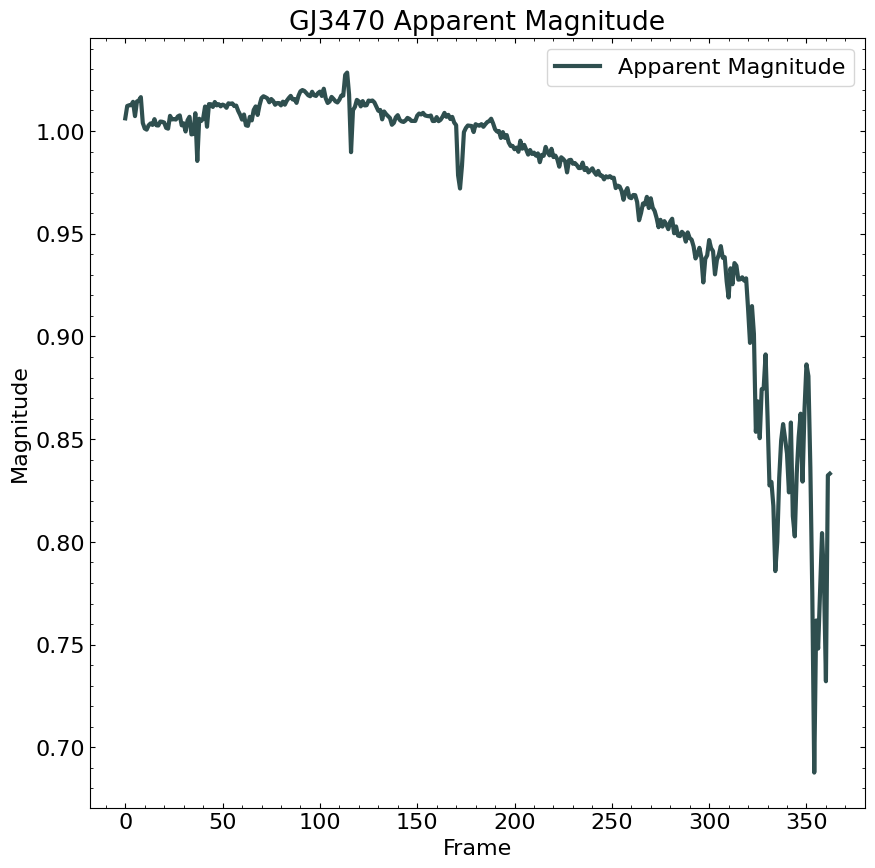

In [18]:
#First we need to extract the photometry of the star.
GJ_coords = [1005, 1046]

mag_exo = calibrator(pos_list, mag_list, GJ_coords, cal_pix)
mag_exo = np.array(mag_exo)
median_exo = np.median(mag_exo)

plt.figure(figsize=(10,10))
plt.plot(frames, mag_exo/median_exo, color="darkslategray", label="Apparent Magnitude") #Dividing the magnitude by the median "normalizes" the light curve
plt.title("GJ3470 Apparent Magnitude")
plt.legend()
plt.xlabel("Frame")
plt.ylabel("Magnitude")

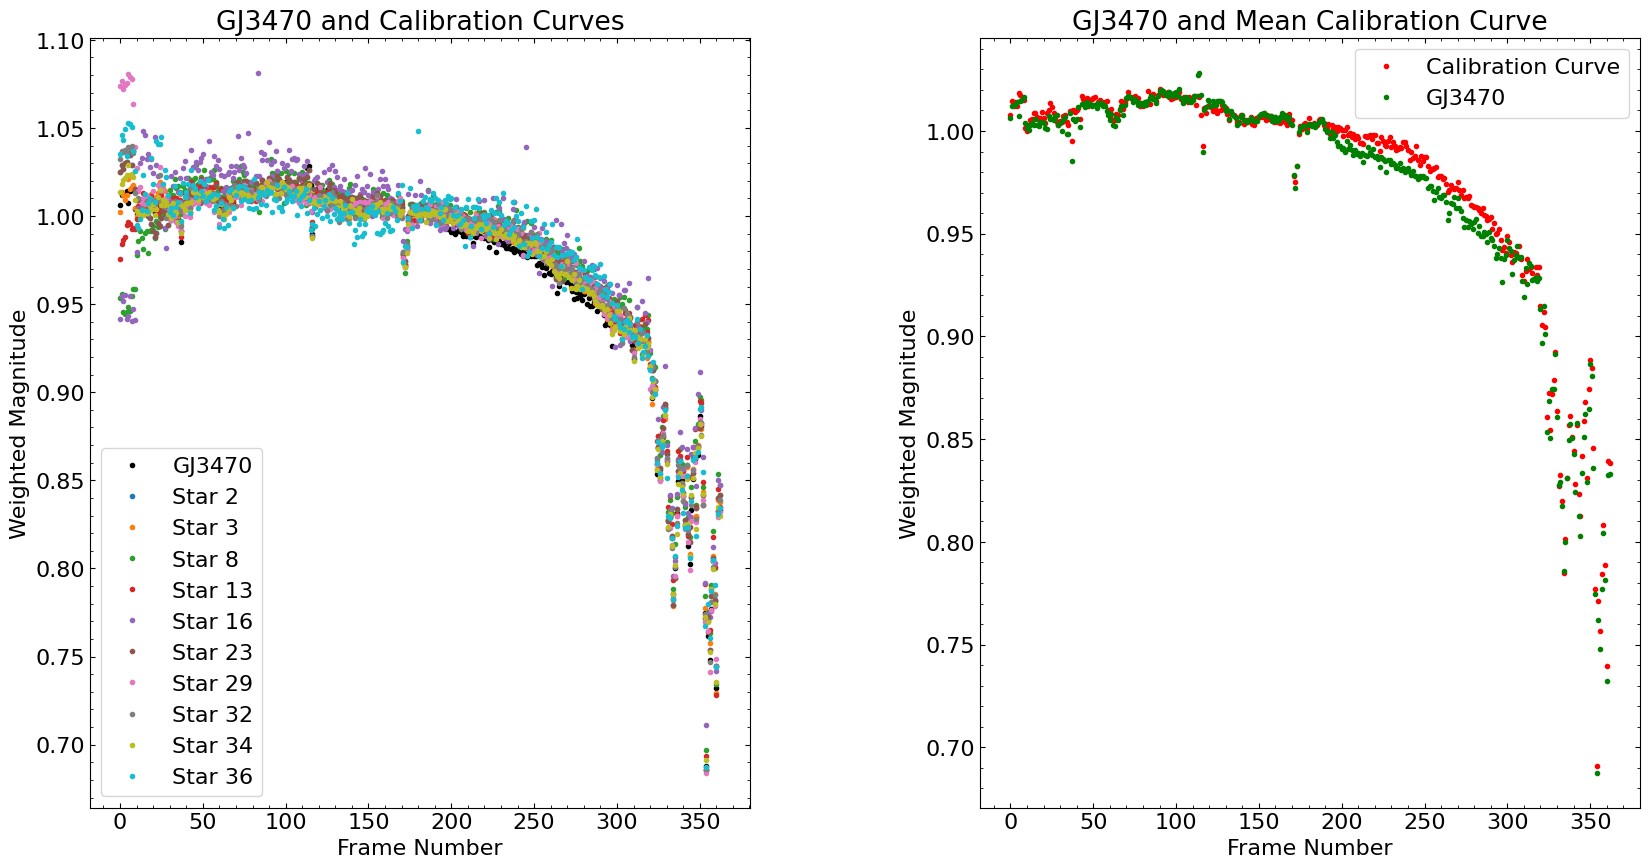

In [19]:
#Now we'll plot a bunch of calibration stars, weighted by their medians

fig, ax = plt.subplots(1,2, figsize=(20, 10), gridspec_kw={'wspace':0.35})

ax[0].plot(frames, mag_exo/median_exo, color="black", linestyle='', marker= '.', label="GJ3470", linewidth='5')

linted_mags = []
nums = 0
for i in range(len(cal_stars)):
    mag_i = calibrator(pos_list, mag_list, cal_stars[i], cal_pix)
    mag_i = np.array(mag_i)
    median_i = np.median(mag_i)
    x = frames
    y = mag_i/median_i
    check = np.abs(mag_exo/median_exo - y)
    if any(check > 0.1): #Check to make sure these stars are not significantly variable.
        pass
    else:
        linted_mags.append(y)
        nums += 1
        ax[0].plot(x, y, linestyle='', marker= '.',label="Star " +str(i), )
        
ax[0].set_title("GJ3470 and Calibration Curves")
ax[0].legend()
ax[0].set_xlabel("Frame Number")
ax[0].set_ylabel("Weighted Magnitude")
#ax[0].set_yscale("log")
ax[0].set_aspect('auto')

#Now we'll make one calibration curve out of all the stars
cal_curve = np.sum(linted_mags, axis=0)/10

ax[1].plot(frames, cal_curve, color = "red", linestyle='', marker= '.', label="Calibration Curve")
ax[1].plot(frames, mag_exo/median_exo, color="green", linestyle='', marker= '.', label="GJ3470")
ax[1].legend()
ax[1].set_xlabel("Frame Number")
ax[1].set_ylabel("Weighted Magnitude")
ax[1].set_title("GJ3470 and Mean Calibration Curve")
ax[1].set_aspect('auto')

Text(0, 0.5, 'Weighted Magnitude Difference from $\\mu$')

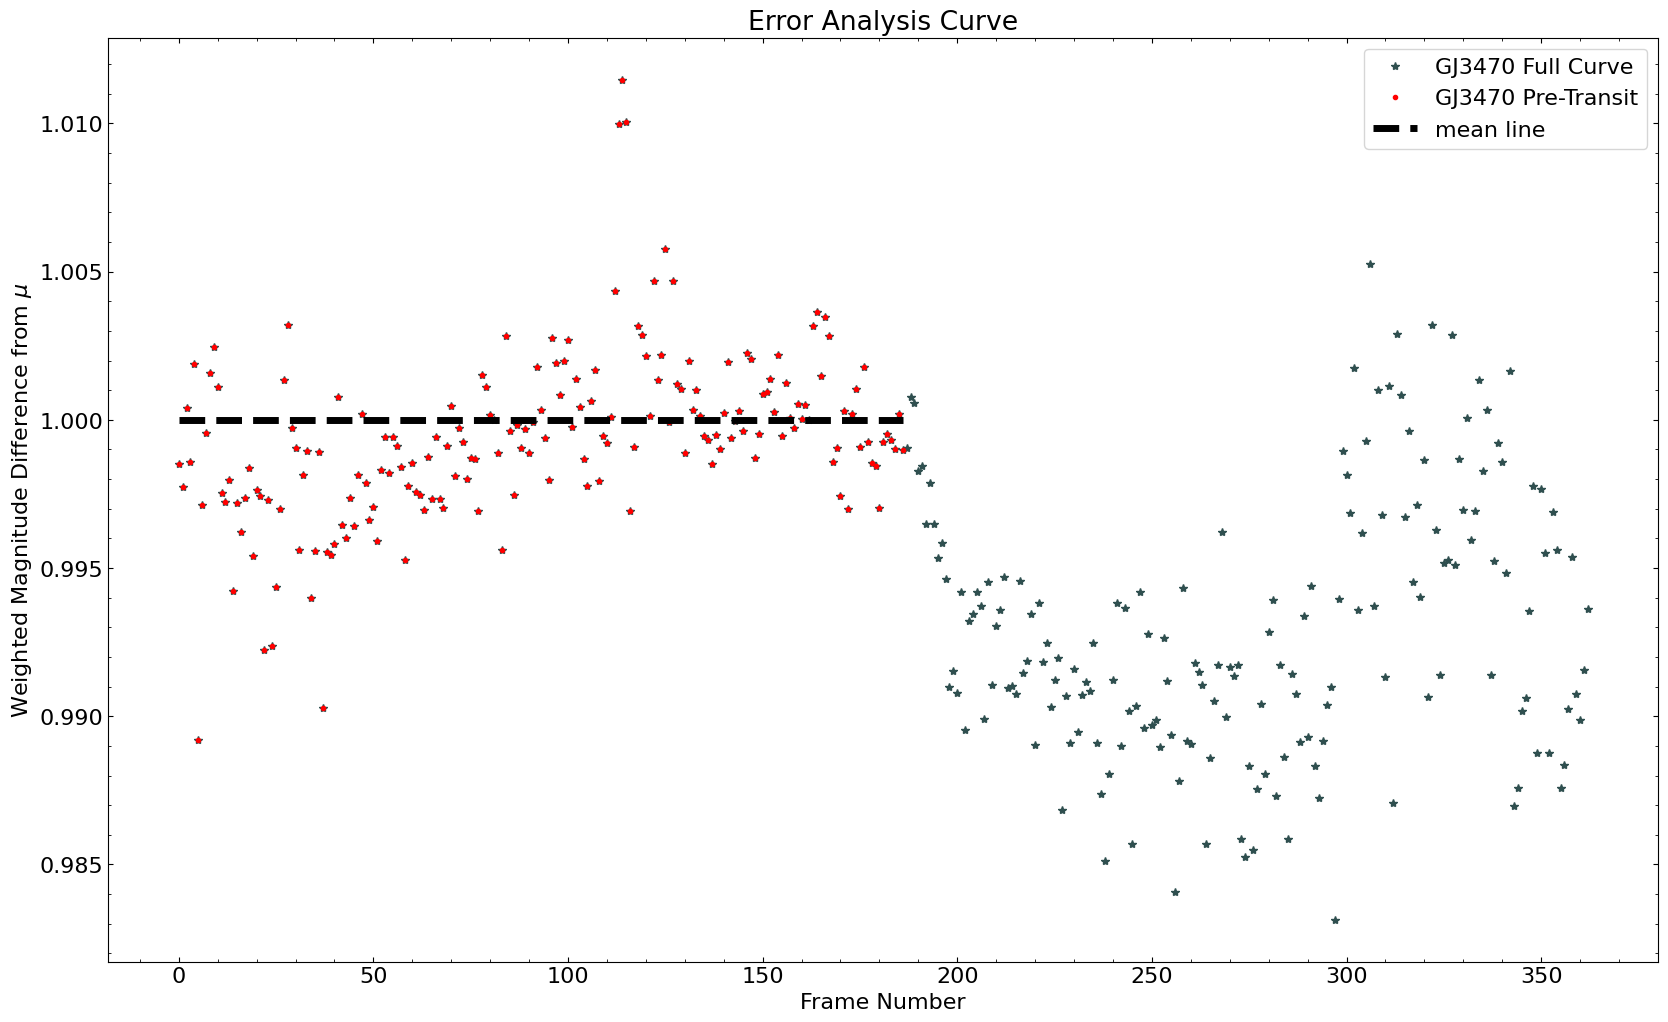

In [20]:
#lets do some error analysis. All the standard deviation can be traced back to the star before the exoplanet begins to transit. So if we lob off the bit of our data after the transit, we can estimate the std from the remaining data.

frames = np.array(frames)
y_data = mag_exo/median_exo/cal_curve
static_frames = frames[frames <187] #This frame where the transit begins was chosen manually.
test_y = np.ones(len(static_frames))
static_mags = y_data[frames < 187]

plt.figure(figsize=(20, 12))
plt.plot(frames, y_data, color="darkslategray", linestyle = '', marker='*', label="GJ3470 Full Curve")
plt.plot(static_frames, static_mags, color="red",linestyle = '', marker = '.', label="GJ3470 Pre-Transit")
plt.plot(static_frames, test_y, color = "black", linestyle="dashed", linewidth="5", label="mean line")
plt.legend()
plt.title("Error Analysis Curve")
plt.xlabel("Frame Number")
plt.ylabel("Weighted Magnitude Difference from $\mu$")

In [21]:
mu = np.mean(static_mags)
sigma = np.std(static_mags)
var = np.var(static_mags)
print("The mean is", mu)
print("The standard deviation is", sigma)
print("The variance is", var)

The mean is 0.9993983798081838
The standard deviation is 0.002828645185485252
The variance is 8.001233585368895e-06


Text(0, 0.5, 'Weighted Magnitude Difference from $\\mu$')

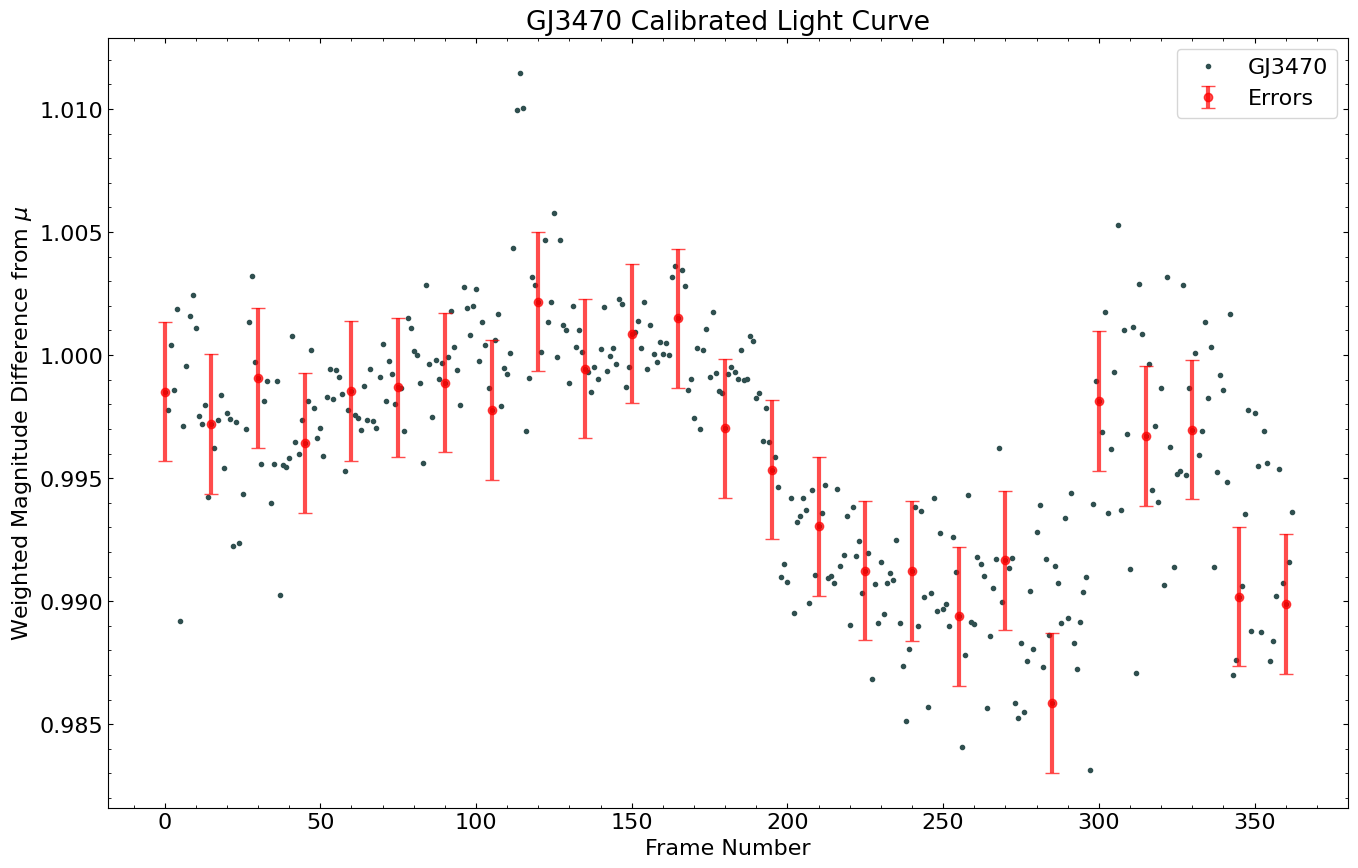

In [22]:
plt.figure(figsize=(16,10))
plt.plot(frames, y_data, color="darkslategray", linestyle = '', marker = '.', label="GJ3470")
plt.errorbar(frames, y_data, xerr=None, yerr=sigma, errorevery=15, color="red", label="Errors", linestyle='', marker='o', markersize=6, markevery=15, capsize=5, alpha=0.7)
plt.legend()
plt.title("GJ3470 Calibrated Light Curve")
plt.xlabel("Frame Number")
plt.ylabel("Weighted Magnitude Difference from $\mu$")

Lets do some statistical analaysis to try to fit a model to this. We'll see how chi squared does for a square wave. I'd like to do this to increase my certainty that there is in fact an exoplanet here.

In [23]:
#Here we'll pull our x and y-data
x_data = np.array(frames)
y_data = mag_exo/median_exo/cal_curve

Text(0, 0.5, 'Magnitude Difference')

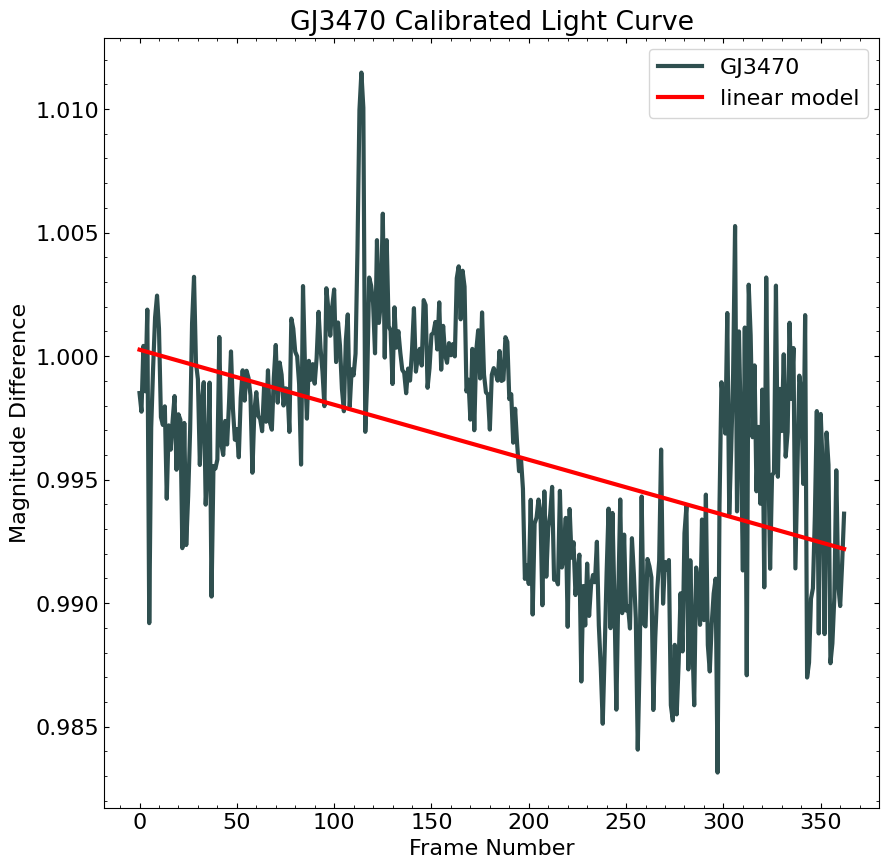

In [24]:
#The null hypothesis is a linear model. I.E There is no dip in signal.

#First we're going to define a chi_squared function

def chisq(model, x, y, sigma, kwargs={}):
    return np.sum((model(x, **kwargs) - y)**2)/sigma**2

#Lets code the linear model. Should be easy. I'm going to rip some of my old code from PHYS 240.

def null_model(x, a0, a1):
    return a0*x + a1

popt, pcov = sp.optimize.curve_fit(null_model, x_data, y_data)

#Plot the null model over it.

plt.figure(figsize=(10,10))
plt.plot(x_data, y_data, color="darkslategray", label="GJ3470")
plt.plot(x_data, null_model(x_data, popt[0], popt[1]), color="red", label="linear model")
plt.title("GJ3470 Calibrated Light Curve")
plt.legend()
plt.xlabel("Frame Number")
plt.ylabel("Magnitude Difference")

In [25]:
kwargs ={'a0':popt[0], 'a1':popt[1]}
print(chisq(null_model, x_data, y_data, sigma, kwargs=kwargs))
print(chisq(null_model, x_data, y_data, sigma, kwargs=kwargs)/len(x_data))
#This chi squared is complete garbage. This model is completely inaccurate, as expected.

837.8702403415283
2.3081824802796924


A good (albeit finnicky) model of a transiting exoplanet is as follows:

$$M = a_0 + a_1\tanh{\Big[a_2 \cos{(a_3 f + a_4)}\Big]} $$

Our optimal parameters are [ 4.27169337e-03  6.00000000e+01  3.04947243e-02 -4.38044231e+00
  9.94886564e-01]


Text(0, 0.5, 'Weighted Magnitude Difference from $\\mu$')

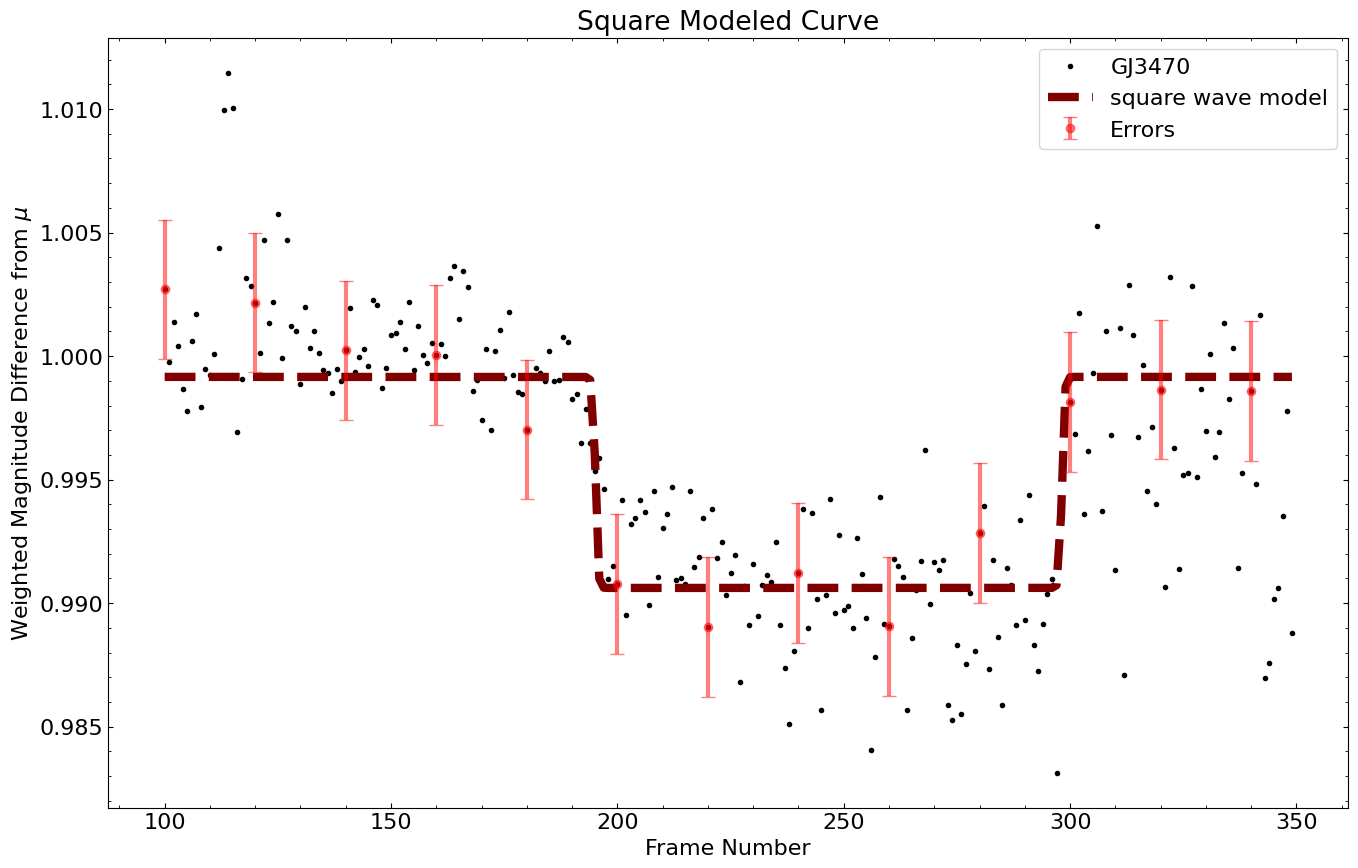

In [36]:
#Now we'll try to fit a square wave to this. This should be a bit nicer.

def square_model(x, a0, a1, a2, a3, a4):
    #We make a fake square wave through some fancy trig. If we use a real square wave scipy will crash and burn.
    return a0*np.tanh(a1*np.cos(a2*x + a3)) + a4
    
x_clipped = np.delete(x_data, np.s_[0:100])
x_clipped = x_clipped[x_clipped < 350]
times_clipped = np.array(times)[x_clipped]
y_clipped = y_data[x_clipped]

popt, pcov = sp.optimize.curve_fit(square_model, x_clipped, y_clipped, bounds=([0.004, 60, 0.02, -5, 0.9],[0.006, 67, 0.04, -3, 1.1]))
print("Our optimal parameters are", popt)

#Plot the model over it.
plt.figure(figsize=(16,10))
plt.plot(x_clipped, y_clipped, color="black", linestyle = '', marker = '.', label="GJ3470")
plt.plot(x_clipped, square_model(x_clipped, popt[0], popt[1], popt[2], popt[3], popt[4]), color="maroon", linewidth=6, linestyle='dashed', label="square wave model")
plt.errorbar(x_clipped, y_clipped, xerr=None, yerr=sigma, errorevery=20, color="red", label="Errors", linestyle='', marker='o', markersize=6, markevery=20, capsize=5, alpha=0.5)
plt.title("Square Modeled Curve")
plt.legend()
plt.xlabel("Frame Number")
plt.ylabel("Weighted Magnitude Difference from $\mu$")

In [33]:
kwargs ={'a0':popt[0], 'a1':popt[1], 'a2':popt[2], 'a3':popt[3], 'a4':popt[4]}
chi_sq = chisq(square_model, x_clipped, y_clipped, sigma, kwargs=kwargs)
delta_chi = chi_sq /(len(x_clipped) - len(popt))
print("The chi_squared was", chi_sq)
print("The chi per data point was", delta_chi)
#This chi squared is much, much better.

upper_mag = square_model(150, popt[0], popt[1], popt[2], popt[3], popt[4])
lower_mag = square_model(250, popt[0], popt[1], popt[2], popt[3], popt[4])

delta_mag = upper_mag - lower_mag
print("The normalized magnitude dip is", delta_mag)

rms = np.sqrt(np.sum((y_clipped - square_model(x_clipped, popt[0], popt[1], popt[2], popt[3], popt[4]))**2)/len(y_clipped))
print("The rms is", rms)

The chi_squared was 360.2439066000249
The chi per data point was 1.4703832922449995
The normalized magnitude dip is 0.00854338674876387
The rms is 0.003395523903265954


In [30]:
class Linmodel:
    def __init__(self):
        self.par = None
        self.y = None
        self.cov = None
        self.cov_inv = None
        
def psuedo_model(c, x_data, y_data, data_ivar=None, data_UT=None):
    A = np.ones((len(x_data), 2))
    A[:, 0] = np.tanh(c[0]*np.cos(c[1]*x_data + c[2]))
    A[:, 1] = 1
        
    result = Linmodel()

    Yfit = np.zeros(len(x_data))
    b = y_data
        
    if data_ivar is not None:
        if data_UT is None: # case of diagonal, 1-D variances
            Ap = A*np.sqrt(data_ivar[:, np.newaxis])
            bp = b*np.sqrt(data_ivar)
            result.cov_inv = np.dot(Ap.T, Ap)  # We need this for part 2c
        else:
            Ap = np.dot(data_UT, A)*np.sqrt(data_ivar)[:, np.newaxis]
            bp = np.dot(data_UT, b)*np.sqrt(data_ivar)
            # I could compute the covariance matrix for the parameters here, but I never use it.
    else:  # Unit variances
        Ap = A
        bp = b
        
    fit = np.linalg.lstsq(Ap, bp, rcond=None)[0]
    Yfit += np.dot(A, fit)

    result.y = Yfit
    result.par = fit
    return result

def chisq_model(par, model, x_data, y_data, kwargs={}):
    if not 'Cdata_inv' in kwargs:
        return np.sum((model(par, x_data, y_data, **kwargs).y - y_data)**2)
    else:
        Cdata_inv = kwargs['Cdata_inv']
        model_args = kwargs.copy()
        del model_args['Cdata_inv']
        resid = model(par, x_data, y_data, **model_args).y - y_data
        return np.linalg.multi_dot([resid, Cdata_inv, resid])

#We use our optimal parameters from before as an initial guess.
cguess = [popt[1], popt[2], popt[3]]
data_ivar = np.ones(x_clipped.shape)/sigma**2
extra_args = {'data_ivar':data_ivar}
par_fit = sp.optimize.minimize(chisq_model, cguess, (psuedo_model, x_clipped, y_clipped, extra_args), method="Powell").x
print("The best-fit parameters are", par_fit)
print("The best-fit chi squared is %.2f" % (chisq_model(par_fit, psuedo_model, x_clipped, y_clipped)/0.025**2))

The best-fit parameters are [18.45002879  0.03044641 -4.38535424]
The best-fit chi squared is 4.59


In [31]:
# Let's establish the best-fit model and the best-fit chi squared.
c = sp.optimize.minimize(chisq_model, cguess, (psuedo_model, x_clipped, y_clipped), method="Powell").x
ivar = np.ones(y_clipped.shape)/sigma**2
result_best = psuedo_model(c, x_clipped, y_clipped, data_ivar=ivar)
chisq_best = np.sum((y_clipped - result_best.y)**2*ivar)

print(c)

# To estimate how far I need to go in c1 and c2, I'll use same computation of 
# delta chisq = 1 that I used above, but in one variable at a time.  This won't
# give any kind of exact result but should produce a rough guess.

for sig_c1 in np.linspace(0, 20, 10000):
    chisq_high = chisq_model([c[0] + sig_c1, c[1], c[2]], psuedo_model, x_clipped, y_clipped)/sigma**2
    if chisq_high > chisq_best + 1:
        break

for sig_c2 in np.linspace(0, 0.1, 1000):
    chisq_high = chisq_model([c[0], c[1] + sig_c2, c[2]], psuedo_model, x_clipped, y_clipped)/sigma**2
    if chisq_high > chisq_best + 1:
        break

for sig_c3 in np.linspace(0, 0.1, 1000):
    chisq_high = chisq_model([c[0], c[1], c[2] + sig_c2], psuedo_model, x_clipped, y_clipped)/sigma**2
    if chisq_high > chisq_best + 1:
        break

print("Rough sig_c1 = %.3g, rough sig_c2 = %.3g, rough sig_c3 = %.3g" % (sig_c1, sig_c2, sig_c3))

[18.45002878  0.03044641 -4.38535424]
Rough sig_c1 = 16, rough sig_c2 = 0.0001, rough sig_c3 = 0.1
